In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tqdm import tqdm
from pykalman import KalmanFilter
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
monthly = pd.date_range('2009-12-31', '2022-1-1', freq='MS')

period_candi = [(3,1),(6,1),(12,1),(24,12)]

formation_train = {}
for cnd in period_candi:

    train_window_width = cnd[0]
    test_window_width = cnd[1]

    train_period = []
    test_period = []
    for i in range(len(monthly)- train_window_width-test_window_width):
        train_start_date = monthly[i]
        train_end_date = monthly[i+train_window_width]
        test_end_date = monthly[i+train_window_width+test_window_width]

        if test_end_date.year < 2017:

            train_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
        
        elif test_end_date.year >=2017:

            test_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
            
    formation_train[cnd] = (train_period, test_period)

performance_test = formation_train[(24,12)][1][48:60]
performance_test

[('2018-01-01', '2020-01-01', '2021-01-01'),
 ('2018-02-01', '2020-02-01', '2021-02-01'),
 ('2018-03-01', '2020-03-01', '2021-03-01'),
 ('2018-04-01', '2020-04-01', '2021-04-01'),
 ('2018-05-01', '2020-05-01', '2021-05-01'),
 ('2018-06-01', '2020-06-01', '2021-06-01'),
 ('2018-07-01', '2020-07-01', '2021-07-01'),
 ('2018-08-01', '2020-08-01', '2021-08-01'),
 ('2018-09-01', '2020-09-01', '2021-09-01'),
 ('2018-10-01', '2020-10-01', '2021-10-01'),
 ('2018-11-01', '2020-11-01', '2021-11-01'),
 ('2018-12-01', '2020-12-01', '2021-12-01')]

In [307]:
def pair_list_sort (pair_data, price_df, idx = 0):

    df_formation = price_df.loc[performance_test[idx][0]:performance_test[idx][1]]
    df_trading = price_df.loc[performance_test[idx][1]:performance_test[idx][2]]

    pair_list = []
    for x in pair_data[idx][0]:
        if x == []:
            pass
        else:
            for pair in x:
                pair_list.append(pair)

    return pair_list, df_formation, df_trading

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife

def getError(theta, state_covs, latest_prices):

    vt = 1e-3
    P = np.zeros((2, 2))
    R = state_covs
    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    return et, sqrt_Qt

def getUpdate(theta, state_covs, latest_prices):
    delta = 1e-4
    wt = delta / (1 - delta) * np.eye(2)
    vt = 1e-3

    P = np.zeros((2, 2))
    R = state_covs

    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    At = R.dot(F.T) / Qt
    new_theta = theta + At.flatten() * et
    C = R - At * F.dot(R)
    new_R = C + wt
    
    return new_theta, new_R

def reg_df_cal (df, entryz = 0.5, exitz = 0, tr=0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
    df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
    df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal (df, entryz = 0.5, exitz = 0, tr=0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
    df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
    df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) 

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe

def reg_df_cal_std (df, entry = 0.5, exit = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.stdev.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) 

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal_std (df, entry = 0.5, exit = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.spread.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) 

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe
    
def reg_df_cal_std_tr (df, entry = 0.5, exit = 0, tr=0.25):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.stdev.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal_std_tr (df, entry = 0.5, exit = 0, tr=0.25):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.stdev.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short'] 
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) * (1 - tr)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe


In [468]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
price_df = price_df.pivot(columns='tic', values='Adj Close', index='Date')
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

pair_data = pd.read_pickle('2020~2021_pair_reg.pkl')


[('SPDN', 'SH'), ('SPY', 'IVV'), ('VONE', 'VV'), ('SPLG', 'SCHX')]

In [481]:
etf_info.head(8)

,Symbol,ETF Name,Asset Class,Total Assets,YTD Price Change,Avg. Daily Volume,Previous Closing Price,1-Day Change,Inverse,Leveraged,...,Returns Rating,Volatility Rating,Dividend Rating,Concentration Rating,ESG Score,ESG Score Peer Percentile (%),ESG Score Global Percentile (%),Carbon Intensity (Tons of CO2e / $M Sales),SRI Exclusion Criteria (%),Sustainable Impact Solutions (%)
0,SPY,SPDR S&P 500 ETF Trust,Equity,"$373,981,000,000",-16.03%,"89,986,616",$394.24,-0.31%,No,False,...,B,B+,A-,A-,8.99,68.23%,82.72%,145.86,6.90%,5.85%
1,IVV,iShares Core S&P 500 ETF,Equity,"$301,697,000,000",-16.03%,"5,046,712",$395.90,-0.34%,No,False,...,B,B+,A-,A-,8.97,65.45%,82.10%,146.07,6.84%,5.80%
2,VOO,Vanguard S&P 500 ETF,Equity,"$273,723,000,000",-16.00%,"4,644,965",$362.39,-0.29%,No,False,...,B,B+,A-,A-,8.98,67.36%,82.48%,146.30,6.94%,5.83%
3,VTI,Vanguard Total Stock Market ETF,Equity,"$268,610,000,000",-17.27%,"4,427,133",$197.49,-0.42%,No,False,...,B-,B,B+,A,8.56,38.66%,73.06%,146.02,6.38%,6.21%
4,QQQ,Invesco QQQ Trust,Equity,"$161,063,000,000",-28.06%,"62,184,340",$284.81,-0.22%,No,False,...,A,C+,B-,B-,8.65,44.02%,75.09%,53.25,2.18%,7.82%
5,VTV,Vanguard Value ETF,Equity,"$103,132,000,000",-2.27%,"2,986,021",$141.15,0.01%,No,False,...,A-,B+,A-,B,9.23,82.22%,87.68%,246.08,12.97%,5.25%
6,VEA,Vanguard FTSE Developed Markets ETF,Equity,"$99,369,600,000",-16.11%,"20,822,700",$42.08,-0.12%,No,False,...,B+,B-,B,A,8.82,39.98%,78.67%,144.99,9.46%,7.31%
7,IEFA,iShares Core MSCI EAFE ETF,Equity,"$87,534,900,000",-16.45%,"14,898,641",$61.09,-0.05%,No,False,...,B+,B,B,A,8.95,46.51%,81.58%,123.55,10.47%,8.32%


In [478]:
df_form.dropna(axis=1)

tic,AADR,AAXJ,ACSI,ACWF,ACWI,ACWV,ACWX,ADRE,AFK,AFTY,...,XSW,XT,XTL,XTN,XWEB,YANG,YINN,YLDE,YPS,YXI
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,59.238956,74.647148,30.812273,29.583393,69.711899,78.783806,46.611935,42.999767,22.264847,18.510736,...,73.725456,35.950588,66.237228,63.795685,69.823372,39.654854,917.540344,26.512812,15.571241,16.837240
2018-02-02,57.435741,72.831917,30.491510,28.840048,68.192245,77.557632,45.550365,41.852741,21.744879,18.427311,...,72.409637,35.229290,65.585365,62.216957,69.416916,41.711029,875.544983,26.512812,15.333003,17.113749
2018-02-05,55.479874,70.729568,29.251551,28.013702,65.482506,75.332352,43.754536,40.398647,20.952139,18.343891,...,70.242981,33.786709,63.251789,59.915440,67.897530,44.354679,811.588806,26.512812,14.704055,17.528505
2018-02-06,56.968231,72.572594,29.127077,28.411366,66.874001,75.659332,44.842644,41.374069,21.727829,18.594158,...,70.430946,34.479534,64.933479,60.752354,66.891075,42.200596,853.776794,25.135736,14.671655,17.212502
2018-02-07,56.319462,70.146095,29.596251,28.072073,66.095856,75.114372,44.019920,40.064472,21.506205,17.565271,...,71.291672,34.204304,64.612267,61.218376,69.213676,48.662876,726.634949,25.135736,15.032823,18.101271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,52.483025,68.072411,35.391838,29.473486,75.469589,92.983192,44.951862,39.783535,18.144495,15.499490,...,104.587502,41.943951,68.983093,62.413788,85.255760,46.818794,344.028748,31.963366,17.140535,19.119633
2020-01-28,52.724346,68.476913,35.725052,29.785156,76.178490,93.288338,45.345440,40.515228,18.089094,15.709235,...,106.067871,42.491726,69.361214,62.908981,86.186256,45.890404,352.102661,31.963366,17.281853,18.979710
2020-01-29,52.956017,68.891045,35.706268,29.666969,76.168915,93.307404,45.373550,40.496464,18.116796,15.676740,...,106.057922,42.442818,67.897186,62.666245,85.772690,44.882149,357.419678,31.794214,17.239653,18.859776


In [474]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 1)
print(pair_list)
pair = pair_list[0]
#pair = ('WMT', 'TGT')

df_f = np.log(df_form.loc[:, pair])
df_t = np.log(df_trade.loc[:, pair])

# df_f = np.log(tmp.loc['2018-01-01' : '2020-01-01', pair])
# df_t = np.log(tmp.loc['2020-01-01' : '2021-01-01', pair])

delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

df_f['kal_beta'] = state_means[:,0]
df_f['spread'] = df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta']

window = half_life(df_f['spread'])
print(window)
# df_f['stdev'] = (df_f['spread'] - df_f['spread'].mean()) /df_f['spread'].std()
#df_f['stdev'] = df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean()

# opt_reg = {}
# for x in np.arange(0, 0.005, 0.0001):
#     opt_reg[x] = reg_sharpe_cal_std(df_f, x, 0)

# opt_std = max(opt_reg, key=opt_reg.get)

# print(opt_std)


state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

kal_beta_arr = list(state_means[:,0])
spread_arr = list(df_f['spread'])
z_arr = []

for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])

    spread_value = (df_t.loc[idx, f'{pair[1]}'] - df_t.loc[idx, f'{pair[0]}'] * state_means_new[-1][0])
    spread_arr.append(spread_value)
    z_value = np.array(spread_arr) / pd.Series(spread_arr).std()

    # spread_mean = pd.Series(spread_arr).rolling(window=window, center=False).mean()
    # spread_std = pd.Series(spread_arr).rolling(window=window, center=False).std()
    # z_value = (spread_arr - spread_mean)/spread_std
    z_arr.append(z_value[-1])
    

df_t['kal_beta'] = kal_beta_arr[len(df_f):]
df_t['stdev'] = [x.item() for x in error_list]

df_t['spread'] = df_t[f'{pair[1]}'] - df_t[f'{pair[0]}'] * df_t['kal_beta']
ma = (df_t['spread']).rolling(window=window+10, center=False).mean()
std = (df_t['spread']).rolling(window=window+10).std()
df_t['zScore'] = (df_t['spread']-ma)/std

#df_t['zScore'] = z_arr


test_df = df_t[[f'{pair[0]}', f'{pair[1]}', 'zScore', 'kal_beta', 'spread']]
test_df = test_df.rename(columns={'zScore': 'z', f'{pair[0]}' : 'x', f'{pair[1]}' : 'y', 'kal_beta':'hedge_ratio'})
test_df

print(reg_sharpe_cal(test_df, 2, 0, 0))
df_t = reg_df_cal(test_df, 2, 0, 0)
df_t 

[('SPDN', 'SH'), ('SPY', 'IVV'), ('MGC', 'FTEC'), ('SPLG', 'SCHX'), ('QQQ', 'VOO'), ('VONE', 'VV')]
3
2.153676839435732


tic,x,y,z,hedge_ratio,spread,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-02-03,3.188417,3.171255,NaN,0.755556,0.762229,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-02-04,3.173073,3.155626,NaN,0.754514,0.761499,False,False,0.0,False,False,0.0,0.0,-0.000131,-0.0,1.00000
2020-02-05,3.162149,3.144496,NaN,0.753661,0.761307,False,False,0.0,False,False,0.0,0.0,-0.000035,-0.0,1.00000
2020-02-06,3.158551,3.141046,NaN,0.753219,0.761967,False,False,0.0,False,False,0.0,0.0,0.000119,0.0,1.00000
2020-02-07,3.163837,3.146646,NaN,0.753351,0.763167,False,False,0.0,False,False,0.0,0.0,0.000217,0.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26,2.884398,2.861057,0.110028,0.740107,0.726295,False,True,0.0,False,False,0.0,0.0,0.000124,0.0,1.00519
2021-01-27,2.908655,2.884801,1.865556,0.741406,0.728306,False,False,0.0,False,False,0.0,0.0,0.000399,0.0,1.00519
2021-01-28,2.901001,2.876949,-0.430945,0.741436,0.726041,False,False,0.0,False,True,0.0,0.0,-0.000450,-0.0,1.00519


<AxesSubplot:xlabel='Date'>

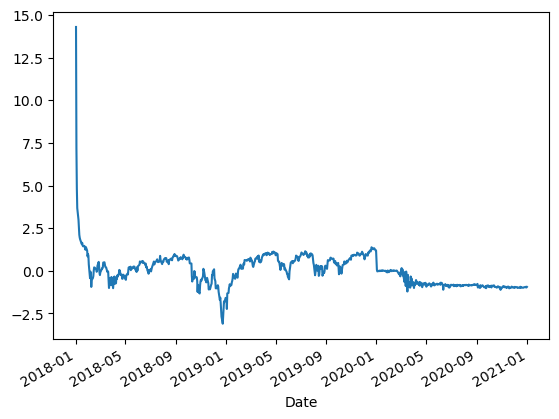

In [466]:
z_score.plot()

In [455]:
long_arr = []
short_arr = []

status = 0 
for num, idx in enumerate(df_t.index):
    if status == 0:
        if df_t.loc[idx,'long entry'] == False:
            pass
        else:
            status = 1
    
    if status == 1:
        if df_t.loc[idx,'long exit'] == False:
            pass
        else:
            status = -1

    if status == -1:
        if df_t.loc[idx,'long entry'] == True:
            status = 1
        else:
            status = 0

    long_arr.append(status)


status = 0 
for num, idx in enumerate(df_t.index):
    if status == 0:
        if df_t.loc[idx,'short entry'] == False:
            pass
        else:
            status = 1
    
    if status == 1:
        if df_t.loc[idx,'short exit'] == False:
            pass
        else:
            status = -1

    if status == -1:
        if df_t.loc[idx,'short entry'] == True:
            status = 1
        else:
            status = 0

    short_arr.append(status)
        
short_arr = np.array(short_arr)
long_arr = np.array(long_arr)


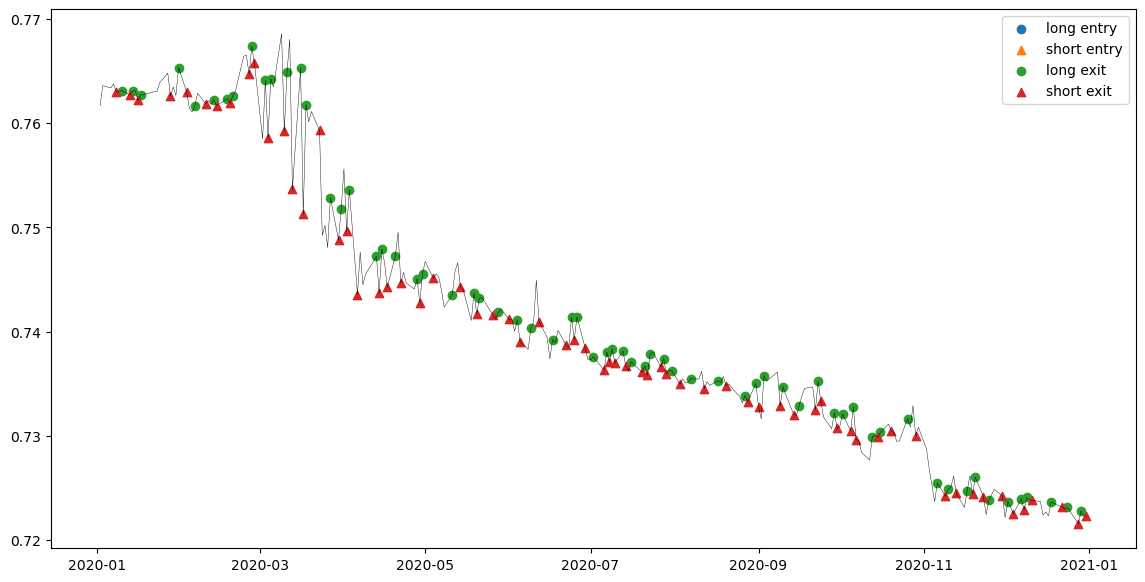

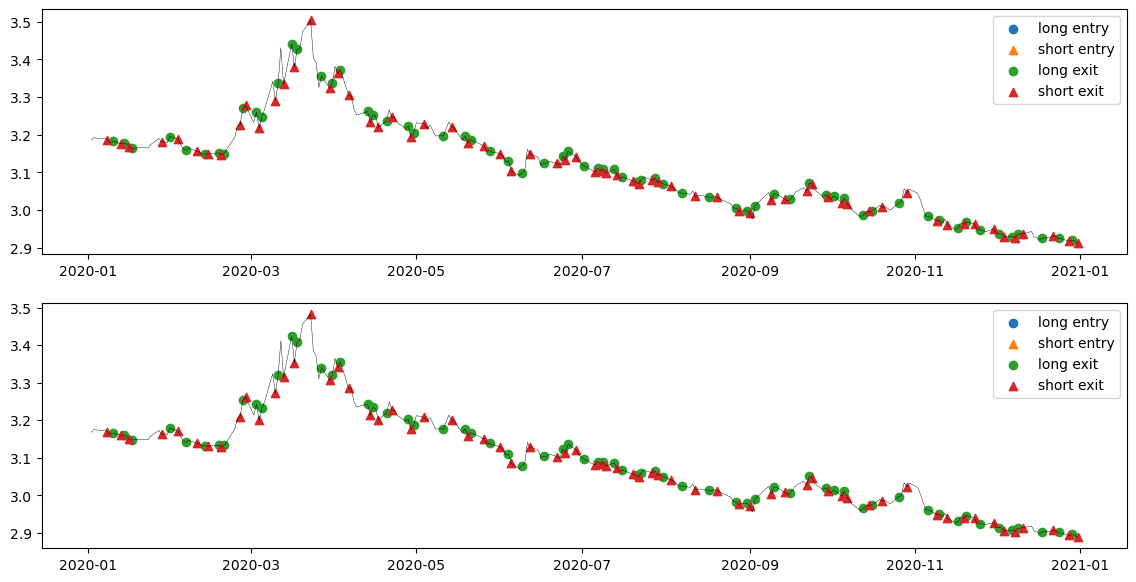

In [456]:
plt.figure(figsize=(14, 7))
plt.plot(df_t.spread, 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(df_t['long entry'] == True, df_t['spread'], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(df_t['short entry'] == True, df_t['spread'], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(df_t['long exit'] == True, df_t['spread'], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(df_t['short exit'] == True, df_t['spread'], np.NaN), marker='^', label='short exit')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.plot(df_t[df_t.columns[0]], 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(df_t['long entry'], df_t[df_t.columns[0]], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(df_t['short entry'], df_t[df_t.columns[0]], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(df_t['long exit'], df_t[df_t.columns[0]], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(df_t['short exit'] == True, df_t[df_t.columns[0]], np.NaN), marker='^', label='short exit')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_t[df_t.columns[1]], 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(df_t['long entry'], df_t[df_t.columns[1]], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(df_t['short entry'], df_t[df_t.columns[1]], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(df_t['long exit'], df_t[df_t.columns[1]], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(df_t['short exit'] == True, df_t[df_t.columns[1]], np.NaN), marker='^', label='short exit')
plt.legend()


In [346]:
df_t['x_inv'] = budget / (df_t['hedge_ratio'] * df_t['x'])
df_t['y_inv'] = budget / df_t['y']
df_t['port'] = np.nan

if idx in enumerate(df_t.index):
    if df_t.loc[idx, 'numUnits'] == 1:
        if df_t.loc[idx, 'numUnits'].shift(1) == 0:
            df_t.loc[idx, 'port'] = 1 * df_t.loc[['x_inv',' y_inv']] * df_t.loc[['x','y']]
        elif df_t.loc[idx, 'numUnits'].shift(1) == -1:
                

tic,x,y,z,hedge_ratio,spread,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets,x_inv,y_inv
Date,,,,,,,,,,,,,,,,,
2020-01-02,36.459435,37.069489,NaN,0.989672,0.986625,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN,2.771399,2.697636
2020-01-03,36.230003,36.816017,NaN,0.988955,0.986187,False,False,0.0,False,False,0.0,0.0,-0.000006,-0.000000,1.000000,2.790971,2.716209
2020-01-06,36.344719,36.954712,NaN,0.989638,0.986586,False,False,0.0,False,False,0.0,0.0,0.000005,0.000000,1.000000,2.780239,2.706015
2020-01-07,36.249126,36.863846,-0.127856,0.989746,0.986432,False,False,0.0,False,False,0.0,0.0,-0.000002,-0.000000,1.000000,2.787269,2.712685
2020-01-08,36.440311,37.031231,-0.697077,0.989152,0.986229,False,False,0.0,False,False,0.0,0.0,-0.000003,-0.000000,1.000000,2.774310,2.700423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,42.283478,43.973625,-1.046098,1.016987,0.971877,True,False,1.0,False,False,0.0,1.0,-0.000004,-0.000000,1.000283,2.325487,2.274090
2020-12-28,42.634293,44.237110,-1.041129,1.014803,0.971704,False,False,1.0,False,False,0.0,1.0,-0.000002,-0.000002,1.000281,2.311315,2.260545
2020-12-29,42.546581,44.124882,0.500084,1.014249,0.972062,False,True,0.0,False,False,0.0,0.0,0.000004,0.000004,1.000286,2.317346,2.266295


In [396]:
long_arr = []
short_arr = []

status = 0 
for num, idx in enumerate(df_t.index):
    if status == 0:
        if df_t.loc[idx,'long entry'] == False:
            pass
        else:
            status = 1
    
    if status == 1:
        if df_t.loc[idx,'long exit'] == False:
            pass
        else:
            status = 0
    long_arr.append(status)


status = 0 
for num, idx in enumerate(df_t.index):
    if status == 0:
        if df_t.loc[idx,'short entry'] == False:
            pass
        else:
            status = 1
    
    if status == 1:
        if df_t.loc[idx,'short exit'] == False:
            pass
        else:
            status = 0
    short_arr.append(status)
        
short_arr = np.array(short_arr)
long_arr = np.array(long_arr)


In [405]:
np.where(short_arr==1, df_t['spread pct ch'], np.nan)

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  1.31010227e-05,  5.42418603e-06,
                   nan,             nan,             nan,             nan,
                   nan,  

In [446]:
long_arr = []
short_arr = []

for num, idx in enumerate(df_t.index):
    if df_t.loc[idx, 'num units long'] == 1:
        try:
            if df_t.iloc[num-1, 7] == 0:
                long_arr.append(1)
            else:
                long_arr.append(0)
        except:
            long_arr.append(0)
    elif df_t.loc[idx, 'num units long'] == 0:
        try:
            if df_t.iloc[num-1, 7] == 1:
                long_arr.append(-1)
            else:
                long_arr.append(0)
        except:
            long_arr.append(0)

for num, idx in enumerate(df_t.index):
    if df_t.loc[idx, 'num units short'] == -1:
        try:
            if df_t.iloc[num-1, 7] == 0:
                short_arr.append(1)
            else:
                short_arr.append(0)
        except:
            short_arr.append(0)
    elif df_t.loc[idx, 'num units short'] == 0:
        try:
            if df_t.iloc[num-1, 7] == -1:
                short_arr.append(-1)
            else:
                short_arr.append(0)
        except:
            short_arr.append(0)

long_arr = np.array(long_arr)
short_arr = np.array(short_arr)

In [388]:
short_arr.sum()

36

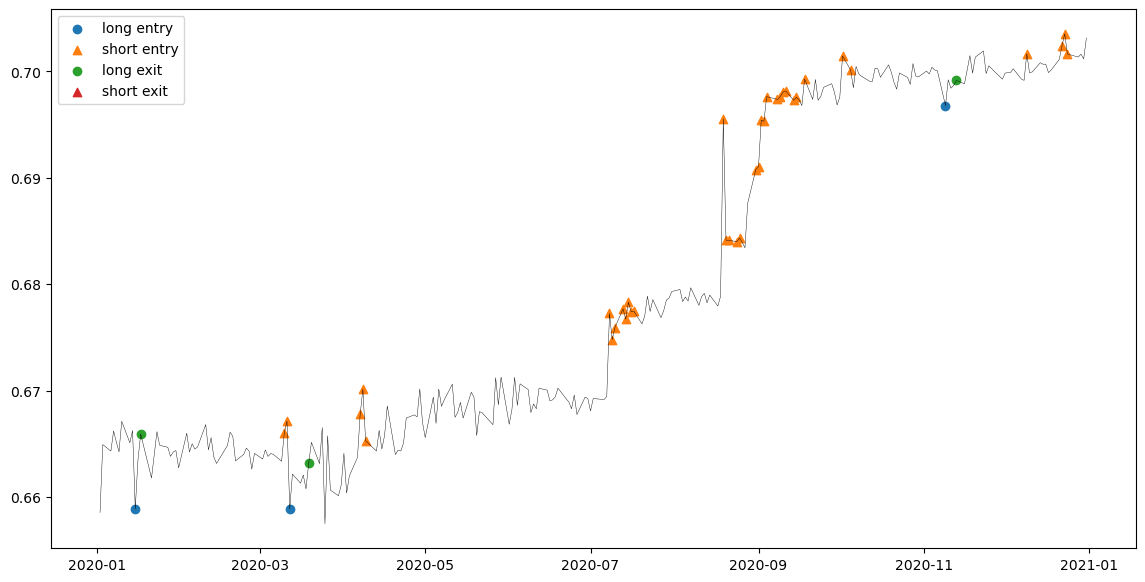

In [389]:
plt.figure(figsize=(14, 7))
plt.plot(df_t.spread, 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(long_arr == 1, df_t['spread'], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(short_arr == 1, df_t['spread'], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(long_arr == -1, df_t['spread'], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(short_arr == -1, df_t['spread'], np.NaN), marker='^', label='short exit')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.plot(df_t[df_t.columns[0]], 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(long_arr == 1, df_t[df_t.columns[0]], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(short_arr == 1, df_t[df_t.columns[0]], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(long_arr == -1, df_t[df_t.columns[0]], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(short_arr == -1, df_t[df_t.columns[0]], np.NaN), marker='^', label='short exit')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_t[df_t.columns[1]], 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(long_arr == -1, df_t[df_t.columns[1]], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(short_arr == +1, df_t[df_t.columns[1]], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(long_arr == 1, df_t[df_t.columns[1]], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(short_arr == +1, df_t[df_t.columns[1]], np.NaN), marker='^', label='short exit')
plt.legend()


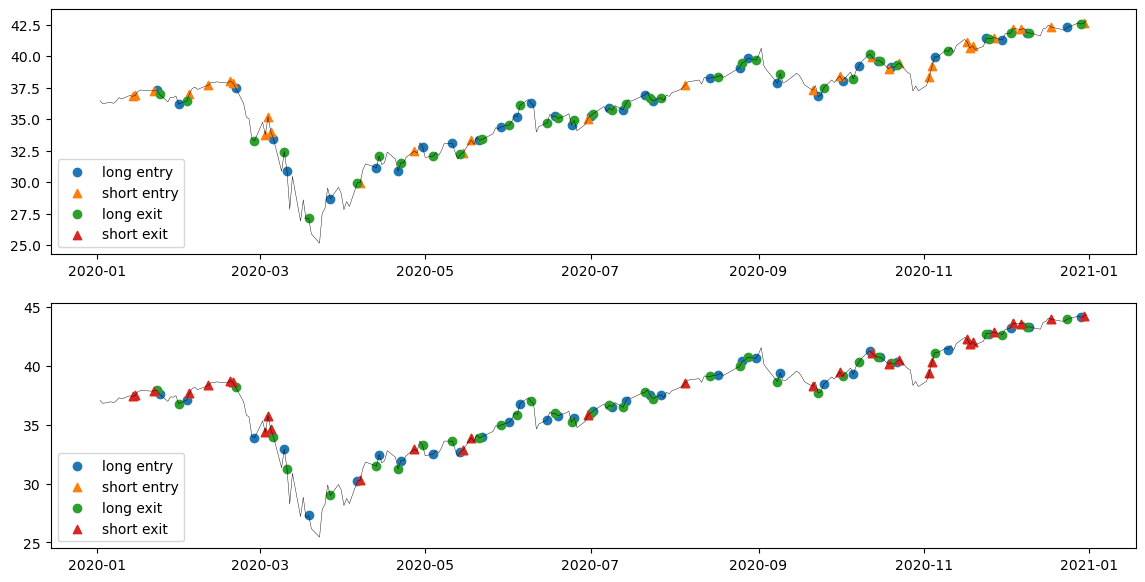

In [374]:
plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.plot(df_t[df_t.columns[0]], 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(long_arr == 1, df_t[df_t.columns[0]], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(short_arr == 1, df_t[df_t.columns[0]], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(long_arr == -1, df_t[df_t.columns[0]], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(short_arr == -1, df_t[df_t.columns[0]], np.NaN), marker='^', label='short exit')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_t[df_t.columns[1]], 'k', linewidth=0.3)
plt.scatter(df_t.index,np.where(long_arr == -1, df_t[df_t.columns[1]], np.NaN), label='long entry')
plt.scatter(df_t.index,np.where(short_arr == +1, df_t[df_t.columns[1]], np.NaN), marker='^', label='short entry')
plt.scatter(df_t.index,np.where(long_arr == 1, df_t[df_t.columns[1]], np.NaN), label='long exit')
plt.scatter(df_t.index,np.where(short_arr == +1, df_t[df_t.columns[1]], np.NaN), marker='^', label='short exit')
plt.legend()


In [157]:
test_df = df_t[[f'log_{pair[0]}', f'log_{pair[1]}', 'kal_spread', 'zScore', 'beta_kal']]
test_df = test_df.rename(columns={'kal_spread': 'spread', f'{pair[0]}' : 'x', f'{pair[1]}' : 'y', 'beta_kal':'hedge_ratio'})

tic,SPDN,SH,kal_beta,stdev,spread,zScore
Date,,,,,,
2020-01-02,24.160183,23.757460,0.943778,-0.044297,0.955620,NaN
2020-01-03,24.339813,23.937288,0.944169,0.009694,0.956392,NaN
2020-01-06,24.250000,23.857363,0.944373,0.005031,0.956326,NaN
2020-01-07,24.309877,23.917309,0.944513,0.003482,0.956306,NaN
2020-01-08,24.199104,23.797421,0.943897,-0.015205,0.955966,NaN
...,...,...,...,...,...,...
2020-12-24,18.631676,18.209999,0.927059,0.022277,0.937334,1.346728
2020-12-28,18.491890,18.049999,0.925506,-0.029805,0.935636,-1.340129
2020-12-29,18.531828,18.100000,0.926147,0.012216,0.936809,0.633543


In [130]:
half_life(df_f['spread'])

1

In [126]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife

In [100]:
reg = {}
reg_df_dict = {}

for trial in tqdm(range(len(pair_data))):
    
    pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)
    
    if pair_list == []:
        reg[trial] = 0
        
        pass
    
    else:
        sharpe_list = []
        reg_df_list = []

        for pair in pair_list:
            
            df_f = df_form.loc[:, pair]
            df_t = df_trade.loc[:, pair]

            delta = 1e-5
            trans_cov = delta / (1-delta) * np.eye(2)
            obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

            kf = KalmanFilter(
                n_dim_obs=1, 
                n_dim_state=2,
                initial_state_mean=np.zeros(2),
                initial_state_covariance=np.ones((2, 2)),
                transition_matrices=np.eye(2),
                observation_matrices=obs_mat,
                observation_covariance=1.0,
                transition_covariance=trans_cov
            )

            state_means, state_covs = kf.filter(df_f[pair[1]])

            df_f['kal_beta'] = state_means[:,0]
            df_f['spread'] = df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta']
            df_f['stdev'] = (df_f['spread'] - df_f['spread'].mean()) /df_f['spread'].std()
            #df_f['stdev'] = df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean()

            opt_reg = {}
            for x in np.arange(, 0.005, 0.0001):
                opt_reg[x] = reg_sharpe_cal_std(df_f, x, 0)

            opt_std = max(opt_reg, key=opt_reg.get)

            print(opt_std)

            state_means_new = []
            state_means_new.append(state_means[-1])
            state_covs_new = []
            state_covs_new.append(state_covs[-1])
            error_list = []
            stdev_list = []

            kal_beta_arr = list(state_means[:,0])
            z_score_list = []

            for num, idx in enumerate(df_t.index):

                # idx = df_t.index[0]
                new_price_1 = df_t.loc[idx, pair[0]]
                new_price_2 = df_t.loc[idx, pair[1]]

                my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
                my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

                state_means_new.append(my_new_theta)
                state_covs_new.append(my_new_R)
                error_list.append(my_error)
                stdev_list.append(my_stdev[0])

                tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
                
                kal_beta_arr.append(state_means_new[-1][0])
                z_score = ((tmp[pair[1]] - tmp[pair[0]] * kal_beta_arr) - (tmp[pair[1]] - tmp[pair[0]] * kal_beta_arr).mean()) / (tmp[pair[1]] - tmp[pair[0]] * kal_beta_arr).std()
                z_score_list.append(z_score[-1])    

            df_t['kal_beta'] = kal_beta_arr[len(df_f):]
            df_t['stdev'] = [x.item() for x in error_list]

            df_t['spread'] = df_t[f'{pair[1]}'] - df_t[f'{pair[0]}'] * df_t['kal_beta'] #- df_t['kal_beta'] # + df_t['stdev']) #- df_t['kal_beta']
            df_t['z'] = z_score_list

            meanSpread = df_t.spread.rolling(window=2).mean()
            stdSpread = df_t.spread.rolling(window=2).std()

        
            df_t['stdev'] = (df_t.spread-meanSpread)/stdSpread

            reg_df = reg_df_cal_std(df_t, opt_std, 0)
            sharpe = reg_sharpe_cal_std(df_t, opt_std, 0)
            sharpe_list.append(sharpe)
            reg_df_list.append(reg_df)
        
        reg_df_dict[trial] = reg_df_list
        reg[trial] = np.mean(sharpe_list)
    #reg_sharpe_cal_std_tr(df_t, opt_std, 0, 0.0025) 


  0%|          | 0/12 [00:00<?, ?it/s]

0.0001
0.0001


  8%|▊         | 1/12 [00:00<00:08,  1.32it/s]

0.0001
0.0001
0.0001
0.0001
0.0007000000000000001


 17%|█▋        | 2/12 [00:02<00:10,  1.04s/it]

0.0001


 25%|██▌       | 3/12 [00:02<00:06,  1.48it/s]

0.0001
0.0001
0.0001


 33%|███▎      | 4/12 [00:03<00:05,  1.41it/s]

0.0001


 42%|████▏     | 5/12 [00:03<00:03,  1.81it/s]

0.0001
0.0001
0.0001


 50%|█████     | 6/12 [00:03<00:03,  1.65it/s]

0.0001
0.0001
0.0001


 58%|█████▊    | 7/12 [00:04<00:03,  1.56it/s]

0.0001


100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

0.0001


In [101]:
reg

{0: 8.556866221356138,
 1: 8.260373349556897,
 2: 9.422919979602757,
 3: 6.271882518331439,
 4: 5.716966605102001,
 5: 7.362484244953374,
 6: 4.511821307641036,
 7: 6.24884302536902,
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [102]:
reg_df_dict[0][0]

tic,IJR,SLY,kal_beta,stdev,spread,z,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,,
2020-07-01,65.164810,56.606876,0.855536,NaN,0.856048,0.022164,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-07-02,65.532692,56.976601,0.856373,0.707107,0.856188,0.023769,False,False,0.0,False,False,0.0,0.0,1.236510e-06,0.000000e+00,1.000000
2020-07-06,66.152298,57.433899,0.855269,-0.707107,0.855882,0.020106,True,False,1.0,False,True,0.0,1.0,-2.686644e-06,-0.000000e+00,1.000000
2020-07-07,64.816284,56.305256,0.855482,0.707107,0.856086,0.022484,False,True,0.0,False,False,-1.0,-1.0,1.828296e-06,1.828296e-06,1.000002
2020-07-08,65.087349,56.519314,0.855209,-0.707107,0.856008,0.021513,True,False,1.0,False,True,0.0,1.0,-6.978414e-07,6.978414e-07,1.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,89.756096,78.010170,0.859601,-0.707107,0.855711,0.013531,True,False,1.0,False,True,0.0,1.0,-1.713065e-06,1.713065e-06,1.000080
2020-12-28,90.097305,78.186310,0.858302,-0.707107,0.855631,0.012369,False,False,1.0,False,False,0.0,1.0,-5.119031e-07,-5.119031e-07,1.000079
2020-12-29,88.556999,77.012047,0.859966,0.707107,0.856030,0.018087,False,True,0.0,False,False,-1.0,-1.0,2.602253e-06,2.602253e-06,1.000082


In [43]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 0)

In [34]:
reg_df['port rets'].mean()/ reg_df['port rets'].std()

0.3593867802842024

In [57]:
reg

{0: 12.6603428942594,
 1: 12.2076016184704,
 2: 11.694941542947959,
 3: 9.832775428039255,
 4: 8.897547552969009,
 5: 9.461809253345734,
 6: 7.965870800395713,
 7: 10.07146803288917,
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [50]:
reg = {}
reg_df_dict = {}

for trial in tqdm(range(len(pair_data))):
    
    pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)
    
    if pair_list == []:
        reg[trial] = 0
        
        pass
    
    else:
        sharpe_list = []
        reg_df_list = []

        for pair in pair_list:
            
            df_f = np.log(df_form.loc[:, pair])
            df_t = np.log(df_trade.loc[:, pair])

            delta = 1e-5
            trans_cov = delta / (1-delta) * np.eye(2)
            obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

            kf = KalmanFilter(
                n_dim_obs=1, 
                n_dim_state=2,
                initial_state_mean=np.zeros(2),
                initial_state_covariance=np.ones((2, 2)),
                transition_matrices=np.eye(2),
                observation_matrices=obs_mat,
                observation_covariance=1.0,
                transition_covariance=trans_cov
            )

            state_means, state_covs = kf.filter(df_f[pair[1]])

            df_f['kal_beta'] = state_means[:,0]
            df_f['spread'] = df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta']
            df_f['stdev'] = df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean()

            opt_reg = {}
            for x in np.arange(0.0001, 0.005, 0.0001):
                opt_reg[x] = reg_sharpe_cal_std(df_f, x, 0)

            opt_std = max(opt_reg, key=opt_reg.get)

            print(opt_std)

            state_means_new = []
            state_means_new.append(state_means[-1])
            state_covs_new = []
            state_covs_new.append(state_covs[-1])
            error_list = []
            stdev_list = []

            kal_beta_arr = list(state_means[:,0])


            for num, idx in enumerate(df_t.index):

                # idx = df_t.index[0]
                new_price_1 = df_t.loc[idx, pair[0]]
                new_price_2 = df_t.loc[idx, pair[1]]

                my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
                my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

                state_means_new.append(my_new_theta)
                state_covs_new.append(my_new_R)
                error_list.append(my_error)
                stdev_list.append(my_stdev[0])

                tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
                
                kal_beta_arr.append(state_means_new[-1][0])

            df_t['kal_beta'] = kal_beta_arr[len(df_f):]
            df_t['stdev'] = [x.item() for x in error_list]

            df_t['spread'] = df_t[f'{pair[1]}'] - df_t[f'{pair[0]}'] * df_t['kal_beta'] #- df_t['kal_beta'] # + df_t['stdev']) #- df_t['kal_beta']

            reg_df = reg_df_cal_std_tr(df_t, opt_std, 0, 0.25)
            sharpe = reg_sharpe_cal_std_tr(df_t, opt_std, 0, 0.25)
            sharpe_list.append(sharpe)
            reg_df_list.append(reg_df)
        
        reg_df_dict[trial] = reg_df_list
        reg[trial] = np.mean(sharpe_list)
    #reg_sharpe_cal_std_tr(df_t, opt_std, 0, 0.0025) 


  0%|          | 0/12 [00:00<?, ?it/s]

0.0021
0.0004


  8%|▊         | 1/12 [00:00<00:06,  1.67it/s]

0.0001
0.0001
0.0001
0.0004
0.0044
0.0001


 25%|██▌       | 3/12 [00:01<00:04,  1.91it/s]

0.0047
0.0009000000000000001
0.0024
0.0047


 42%|████▏     | 5/12 [00:02<00:02,  2.40it/s]

0.0001
0.0001
0.0001
0.0001


 50%|█████     | 6/12 [00:03<00:02,  2.10it/s]

0.0016
0.0001


 58%|█████▊    | 7/12 [00:03<00:02,  1.99it/s]

0.0018000000000000002
0.004900000000000001


100%|██████████| 12/12 [00:03<00:00,  3.12it/s]


In [51]:
reg

{0: 6.9385296097465465,
 1: 6.333439427112749,
 2: 3.8849849040431965,
 3: 5.7489258214054,
 4: 7.784998932263927,
 5: 5.533196890055083,
 6: 5.14938706660329,
 7: 5.585094872154291,
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [99]:
reg = {}

for trial in tqdm(range(len(pair_data))):
    
    pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)
    
    if pair_list == []:
        reg[trial] = 0
        pass
    
    else:
        sharpe_list = []
        reg_df_list = []
        for pair in pair_list:

            df_f = df_form.loc[:, pair]
            df_t = df_trade.loc[:, pair]

            # df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
            # df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

            delta = 1e-5
            trans_cov = delta / (1-delta) * np.eye(2)
            obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

            kf = KalmanFilter(
                n_dim_obs=1, 
                n_dim_state=2,
                initial_state_mean=np.zeros(2),
                initial_state_covariance=np.ones((2, 2)),
                transition_matrices=np.eye(2),
                observation_matrices=obs_mat,
                observation_covariance=1.0,
                transition_covariance=trans_cov
            )

            state_means, state_covs = kf.filter(df_f[pair[1]])

            state_means.shape

            stdev_of_mean = (state_means[:,0] * df_f[pair[0]] - df_f[pair[1]]).std()
            state_means_new = []
            state_means_new.append(state_means[-1])
            state_covs_new = []
            state_covs_new.append(state_covs[-1])
            error_list = []
            stdev_list = []


            kal_beta_arr = list(state_means[:,0])

            for num, idx in enumerate(df_t.index):

                # idx = df_t.index[0]
                new_price_1 = df_t.loc[idx, pair[0]]
                new_price_2 = df_t.loc[idx, pair[1]]

                my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
                my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

                state_means_new.append(my_new_theta)
                state_covs_new.append(my_new_R)
                error_list.append(my_error)
                stdev_list.append(my_stdev[0])

                tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
                
                kal_beta_arr.append(state_means_new[-1][0])

                updated_spread = tmp[pair[0]] * kal_beta_arr - tmp[pair[1]]
                normalized_value = (updated_spread - updated_spread.mean())/updated_spread.std()

                df_t.loc[idx,'z_kal_spread'] = normalized_value[-1]

            neg_stdev_list = []
            for s in stdev_list:
                neg_stdev_list.append(s*-1)

            df_t['error_kal'] = [x.item() for x in error_list]
            df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

            x = sm.add_constant(df_f[pair[0]])
            y = df_f[pair[1]]
            model = sm.OLS(y, x).fit()

            beta, intercept = model.params[1], model.params[0]

            df_t['beta_ols'] = [ beta for x in df_t.index]

            ''' pair1 매수, pair2 매도한 스프레드 '''

            df_t['kal_spread'] = np.log(df_t[f'{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'{pair[1]}'])
            df_t['ols_spread'] = np.log(df_t[f'{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'{pair[1]}'])

            df_t['z_ols_spread'] = (df_t['ols_spread'] - df_t['ols_spread'].mean()) / df_t['ols_spread'].std()


            df_t['z_kal_spread_after'] = (df_t['kal_spread'] - df_t['kal_spread'].mean()) / df_t['kal_spread'].std()

            # plt.plot(df_t['kal_spread'], label='kal')
            # plt.plot(df_t['ols_spread'], label='ols')
            # plt.legend()
            # plt.show()
            
            cum_mean = np.cumsum(df_t.kal_spread.to_numpy()) / np.arange(1, len(df_t)+1)
            #aaa = (df_t.kal_spread - cum_mean) / stdev_of_mean

            # plt.plot(aaa)
            # plt.axhline(0.2)
            # plt.axhline(-0.2)
            # df_t['z'] = aaa

            test_df = df_t[[f'{pair[0]}', f'{pair[1]}', 'kal_spread', 'beta_kal']]
            test_df = test_df.rename(columns={'kal_spread': 'spread', f'{pair[0]}' : 'x', f'{pair[1]}' : 'y', 'beta_kal':'hedge_ratio'})
            #reg_df_cal(test_df, 0.1, -0.1)

                        
            meanSpread = test_df.spread.rolling(window=2).mean()
            stdSpread = test_df.spread.rolling(window=2).std()
    
        
            test_df['z'] = (test_df.spread-meanSpread)/stdSpread

            sharpe = reg_sharpe_cal(test_df, 1, 0)
            
            sharpe_list.append(sharpe)
            reg_df_list.append(reg_df)

        reg[trial] = sharpe_list
        reg_df_dict[trial] = reg_df_list
reg

100%|██████████| 12/12 [00:02<00:00,  5.82it/s]


{0: [0.0, 0.0, 0.0],
 1: [0.0, 0.0, 0.0, 0.0, 0.0],
 2: [0.0],
 3: [0.0, 0.0, 0.0],
 4: [0.0],
 5: [0.0, 0.0, 0.0],
 6: [0.0, 0.0, 0.0],
 7: [0.0],
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [93]:
reg

{0: [1.0714027394370171, 1.2816111040701719, 1.4014778468524507],
 1: [0.1593448984785793,
  -0.08166433949548753,
  1.6934396349528051,
  2.165413377361888,
  -0.2751577624741605],
 2: [1.6237059495253463],
 3: [3.3842449894438897, 2.4046008370198564, 3.5604518528823648],
 4: [0.400157708167693],
 5: [2.320199211550064, 3.5595341211358065, 2.888841619851525],
 6: [0.9405237037706184, 3.522390702285189, 3.517901035950636],
 7: [0.0],
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [94]:
test = reg_df_dict[3][0]
test

tic,DOG,SKF,kal_beta,stdev,spread,z,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,,
2021-02-01,39.590000,31.860001,0.777985,-0.005599,1.059559,0.142561,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2021-02-02,38.939999,30.600000,0.758757,-0.754355,1.053999,0.140344,False,False,0.0,False,False,0.0,0.0,-0.000092,-0.000000,1.000000
2021-02-03,38.910000,30.459999,0.755640,-0.122147,1.058029,0.141467,False,False,0.0,False,False,0.0,0.0,0.000067,0.000000,1.000000
2021-02-04,38.480000,29.280001,0.733566,-0.855868,1.052377,0.139215,False,False,0.0,False,False,0.0,0.0,-0.000098,-0.000000,1.000000
2021-02-05,38.369999,29.139999,0.731884,-0.065008,1.057594,0.140762,False,False,0.0,False,False,0.0,0.0,0.000091,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,33.349998,19.639999,0.557803,-0.096267,1.037281,0.108996,False,False,1.0,False,False,0.0,1.0,0.000004,0.000004,1.005579
2021-07-27,33.419998,19.580000,0.554842,-0.099895,1.037190,0.108811,False,False,1.0,False,False,0.0,1.0,-0.000002,-0.000002,1.005577
2021-07-28,33.540001,19.700001,0.556394,0.052540,1.038549,0.109238,False,True,0.0,False,False,-1.0,-1.0,0.000035,0.000035,1.005612


In [88]:
(test['spread'] * test['long entry'] * 0.0025 + test['spread'] * test['short entry'] * 0.0025).sum()


0.07847438345600528

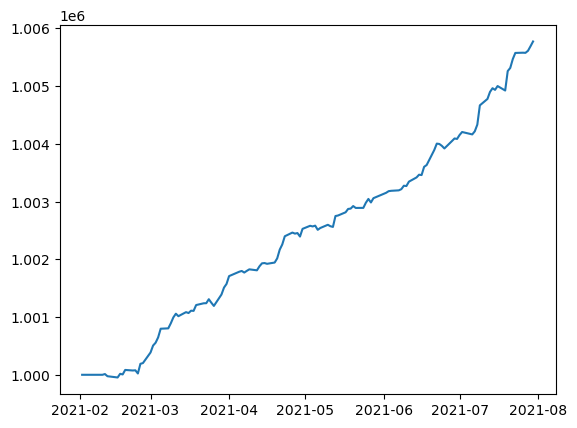

In [95]:
plt.plot(reg_df_dict[0][0]['cum rets'] * 1000000)

In [109]:
len(kal_beta_arr[len(df_f):])

128

In [110]:
df_t.shape

(128, 2)

In [161]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 0)

# if pair_list == []:
#     reg[trial] = 0
#     pass

# else:
#     sharpe_list = []
#     reg_df_list = []
#    for pair in pair_list:
pair = pair_list[0]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

# df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
# df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

kal_beta_arr = list(state_means[:,0])

for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])

df_t['hr'] = - np.array(kal_beta_arr[len(df_f):])
df_t['spread'] = df_t[pair[1]] + (df_t[pair[0]] * df_t.hr)

##############################################################

halflife = half_life(df_t['spread'])

##########################################################

meanSpread = df_t.spread.rolling(window=halflife).mean()
stdSpread = df_t.spread.rolling(window=halflife).std()

    
df_t['zScore'] = (df_t.spread-meanSpread)/stdSpread

##############################################################

entryZscore = 1
exitZscore = 0

# Set up num units long             
df_t['long entry'] = ((df_t.zScore < - entryZscore) & ( df_t.zScore.shift(1) > - entryZscore))
df_t['long exit'] = ((df_t.zScore > - exitZscore) & (df_t.zScore.shift(1) < - exitZscore)) 
df_t['num units long'] = np.nan 
df_t.loc[df_t['long entry'],'num units long'] = 1 
df_t.loc[df_t['long exit'],'num units long'] = 0
df_t['num units long'][0] = 0 
df_t['num units long'] = df_t['num units long'].fillna(method='pad')

# Set up num units short 
df_t['short entry'] = ((df_t.zScore >  entryZscore) & ( df_t.zScore.shift(1) < entryZscore))
df_t['short exit'] = ((df_t.zScore < exitZscore) & (df_t.zScore.shift(1) > exitZscore))
df_t.loc[df_t['short entry'],'num units short'] = -1
df_t.loc[df_t['short exit'],'num units short'] = 0
df_t['num units short'][0] = 0
df_t['num units short'] = df_t['num units short'].fillna(method='pad')

df_t['numUnits'] = df_t['num units long'] + df_t['num units short']
df_t['spread pct ch'] = (df_t['spread'] - df_t['spread'].shift(1)) / ((df_t[pair[0]] * abs(df_t['hr'])) + df_t[pair[1]])
df_t['port rets'] = df_t['spread pct ch'] * df_t['numUnits'].shift(1)

df_t['cum rets'] = df_t['port rets'].cumsum()
df_t['cum rets'] = df_t['cum rets'] + 1

try:
    sharpe = ((df_t['port rets'].mean() / df_t['port rets'].std()) * np.sqrt(252)) 
except ZeroDivisionError:
    sharpe = 0.0

#############################################################
df_t

tic,IJR,SLY,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-07-01,65.164810,56.606876,-0.866037,0.171711,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-07-02,65.532692,56.976601,-0.866816,0.171833,NaN,False,False,0.0,False,False,0.0,0.0,1.065136e-06,0.000000e+00,1.000000
2020-07-06,66.152298,57.433899,-0.865609,0.171906,NaN,False,False,0.0,False,False,0.0,0.0,6.397796e-07,0.000000e+00,1.000000
2020-07-07,64.816284,56.305256,-0.866029,0.172460,NaN,False,False,0.0,False,False,0.0,0.0,4.929306e-06,0.000000e+00,1.000000
2020-07-08,65.087349,56.519314,-0.865712,0.172387,NaN,False,False,0.0,False,False,0.0,0.0,-6.474820e-07,-0.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,89.756096,78.010170,-0.867179,0.175572,-0.986290,False,False,0.0,False,True,0.0,0.0,-1.569143e-06,1.569143e-06,0.999997
2020-12-28,90.097305,78.186310,-0.865849,0.175614,-1.120013,True,False,1.0,False,False,0.0,1.0,2.711263e-07,0.000000e+00,0.999997
2020-12-29,88.556999,77.012047,-0.867636,0.176806,2.578765,False,True,0.0,True,False,-1.0,-1.0,7.746374e-06,7.746374e-06,1.000005


In [162]:
sharpe

0.24022678541573292

In [114]:
from enum import IntEnum

class Col(IntEnum):
    S1 = 0
    S2 = 1
    ZSCORE = 2
    S1BUY = 3
    S1SELL = 4
    S1PROFIT = 5
    S1PERFORMANCE = 6
    S2BUY = 7
    S2SELL = 8
    S2PROFIT = 9
    S2PERFORMANCE = 10
    
def _is_exit(df: pd.DataFrame, i: int) -> bool:
    return abs(df.iat[i, Col.ZSCORE]) < 0.001 or (
        df.iat[i - 1, Col.ZSCORE] > 0.001
        and df.iat[i, Col.ZSCORE] < -0.001
        or (
            df.iat[i - 1, Col.ZSCORE] < -0.01
            and df.iat[i, Col.ZSCORE] > 0.001
        )
    )


In [115]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 0)


pair = pair_list[0]


df_t = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

df_t = pd.concat([df_f, df_t], axis=0)

# df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
# df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance= 0.01,
)
state_means, state_cov = kf.filter(df_t[pair[0]] / df_t[pair[1]])
state_means, state_std = state_means.squeeze(), np.std(
    state_cov.squeeze()
)

ma = (df_t[pair[0]] / df_t[pair[1]]).rolling(window=2, center=False).mean()

df_t = df_t.loc[df_trade.index[0]:, :]

df_t["zscore"] = (ma - state_means) / state_std
df_t["s1Buy"] = df_t["s1Sell"] = df_t["s1Profit"] = df_t["s1Performance"] = np.nan
df_t["s2buy"] = df_t["s2Sell"] = df_t["s2Profit"] = df_t["s2Performance"] = np.nan
s1Profit = [np.nan, np.nan]
s2Profit = [np.nan, np.nan]
s1Performance = s2Performance = 0.0
flag = 0

In [116]:
df_t.head()

tic,SPDN,SH,zscore,s1Buy,s1Sell,s1Profit,s1Performance,s2buy,s2Sell,s2Profit,s2Performance
Date,,,,,,,,,,,
2020-01-02,24.160183,23.757460,0.025452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,24.339813,23.937288,0.033061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,24.250000,23.857363,0.019176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,24.309877,23.917309,0.007989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,24.199104,23.797421,0.016004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
for i in range(len(df_t)):
    if _is_exit(df_t, i):
        if flag == 1:
            if not np.isnan(s1Profit[0]):
                df_t.iat[i, Col.S1SELL] = df_t.iat[i, Col.S1]
                df_t.iat[i, Col.S1PROFIT] = (
                    df_t.iat[i, Col.S1SELL] - s1Profit[0]
                )
            elif not np.isnan(s1Profit[1]):
                df_t.iat[i, Col.S1BUY] = df_t.iat[i, Col.S1]
                df_t.iat[i, Col.S1PROFIT] = (
                    s1Profit[1] - df_t.iat[i, Col.S1BUY]
                )
            s1Profit = [np.nan, np.nan]
            s1Performance += df_t.iat[i, Col.S1PROFIT]
            if not np.isnan(s2Profit[0]):
                df_t.iat[i, Col.S2SELL] = df_t.iat[i, Col.S2]
                df_t.iat[i, Col.S2PROFIT] = (
                    df_t.iat[i, Col.S2SELL] - s2Profit[0]
                )
            elif not np.isnan(s2Profit[1]):
                df_t.iat[i, Col.S2BUY] = df_t.iat[i, Col.S2]
                df_t.iat[i, Col.S2PROFIT] = (
                    s2Profit[1] - df_t.iat[i, Col.S2BUY]
                )
            s2Profit = [np.nan, np.nan]
            s2Performance += df_t.iat[i, Col.S2PROFIT]
        flag = 0
    elif df_t.iat[i, Col.ZSCORE] > 0.1:
        if flag == 0:
            df_t.iat[i, Col.S1SELL] = df_t.iat[i, Col.S1]
            s1Profit = [np.nan, df_t.iat[i, Col.S1SELL]]
            df_t.iat[i, Col.S2BUY] = df_t.iat[i, Col.S2]
            s2Profit = [df_t.iat[i, Col.S2BUY], np.nan]
            flag = 1
    elif df_t.iat[i, Col.ZSCORE] < -0.1:
        if flag == 0:
            df_t.iat[i, Col.S1BUY] = df_t.iat[i, Col.S1]
            s1Profit = [df_t.iat[i, Col.S1BUY], np.nan]
            df_t.iat[i, Col.S2SELL] = df_t.iat[i, Col.S2]
            s2Profit = [np.nan, df_t.iat[i, Col.S2SELL]]
            flag = 1

    df_t.iat[i, Col.S1PERFORMANCE] = s1Performance
    df_t.iat[i, Col.S2PERFORMANCE] = s2Performance

df_t

tic,SPDN,SH,zscore,s1Buy,s1Sell,s1Profit,s1Performance,s2buy,s2Sell,s2Profit,s2Performance
Date,,,,,,,,,,,
2020-01-02,24.160183,23.757460,0.025452,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
2020-01-03,24.339813,23.937288,0.033061,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
2020-01-06,24.250000,23.857363,0.019176,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
2020-01-07,24.309877,23.917309,0.007989,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
2020-01-08,24.199104,23.797421,0.016004,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,18.631676,18.209999,0.023151,NaN,NaN,NaN,-0.251375,NaN,NaN,NaN,0.909107
2020-12-28,18.491890,18.049999,0.012511,NaN,NaN,NaN,-0.251375,NaN,NaN,NaN,0.909107
2020-12-29,18.531828,18.100000,0.029385,NaN,NaN,NaN,-0.251375,NaN,NaN,NaN,0.909107


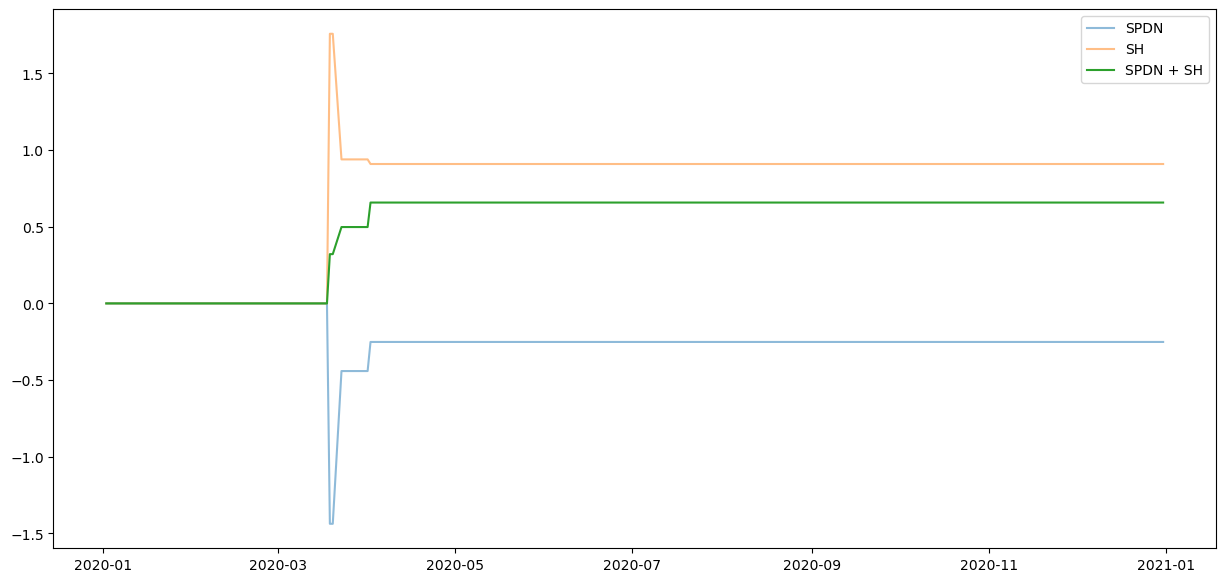

In [118]:
plt.figure(figsize=(15, 7))
plt.plot(df_t.index, df_t["s1Performance"].values, alpha=0.5)
plt.plot(df_t.index, df_t["s2Performance"].values, alpha=0.5)
plt.plot(
df_t.index, df_t["s1Performance"].values + df_t["s2Performance"].values
)
plt.legend(
[
    pair[0],
    pair[1],
    "{} + {}".format(pair[0], pair[1]),
]
)
plt.show()

In [119]:
win_num = (df_t["s1Profit"] > 0).sum() + (df_t["s2Profit"] > 0).sum()
loss_num = (df_t["s1Profit"] <= 0).sum() + (df_t["s2Profit"] <= 0).sum()
total_trades = win_num + loss_num
win = (
    df_t["s1Profit"].where(df_t["s1Profit"] > 0, 0).sum()
    + df_t["s2Profit"].where(df_t["s2Profit"] > 0, 0).sum()
)
loss = (
    df_t["s1Profit"].where(df_t["s1Profit"] <= 0, 0).sum()
    + df_t["s2Profit"].where(df_t["s2Profit"] <= 0, 0).sum()
)
total_profit = df_t["s1Profit"].sum() + df_t["s2Profit"].sum()
win_rate = win_num / total_trades
profit_factor = win / abs(loss)
average_win = win / win_num
average_loss = abs(loss) / loss_num
riskreward_ratio = average_win / average_loss
mdd = (
    np.maximum.accumulate(df_t["s1Performance"] + df_t["s2Performance"])
    - (df_t["s1Performance"] + df_t["s2Performance"])
).max()
sharpe_ratio = (df_t["s1Profit"].mean() + df_t["s2Profit"].mean()) / (
    df_t["s1Profit"].std() + df_t["s2Profit"].std()
)

r = {}

r["total_profit"] = total_profit
r["total_trades"] = total_trades
r["win_rate"] = win_rate
r["profit_factor"] = profit_factor
r["riskreward_ratio"] = riskreward_ratio
r["sharpe_ratio"] = sharpe_ratio
r["maximum_drawdown"] = mdd

In [120]:
r

{'total_profit': 0.6577320098876953,
 'total_trades': 6,
 'win_rate': 0.5,
 'profit_factor': 1.2876889924490613,
 'riskreward_ratio': 1.2876889924490613,
 'sharpe_ratio': 0.08564240460293,
 'maximum_drawdown': 0.0}

In [122]:
import statsmodels.api as sm

class KalmanPairTrade(object):

    def __init__(self, y, x, leverage=1.0, initial_bars=10, 
                 freq='1d', delta=1e-3, maxlen=3000):
        self._y = y
        self._x = x
        self.maxlen = maxlen
        self.initial_bars = initial_bars
        self.freq = freq
        self.delta = delta
        self.leverage = leverage
        self.Y = KalmanMovingAverage(self._y, maxlen=self.maxlen)
        self.X = KalmanMovingAverage(self._x, maxlen=self.maxlen)
        self.kf = None
        self.entry_dt = pd.Timestamp('1900-01-01', tz='utc')
        
    @property
    def name(self):
        return "{}~{}".format(self._y.symbol, self._x.symbol)

    def trading_logic(self, context, data):
        try:
            if self.kf is None:
                self.initialize_filters(context, data)
                return
            self.update(context, data)
            if get_open_orders(self._x) or get_open_orders(self._y):
                return
            spreads = self.mean_spread()

            zscore = (spreads[-1] - spreads.mean()) / spreads.std()

            reference_pos = context.portfolio.positions[self._y].amount

            now = get_datetime()
            if reference_pos:
                if (now - self.entry_dt).days > 20:
                    order_target(self._y, 0.0)
                    order_target(self._x, 0.0)
                    return
                # Do a PNL check to make sure a reversion at least covered trading costs
                # I do this because parameter drift often causes trades to be exited
                # before the original spread has become profitable.
                pnl = self.get_pnl(context, data)
                if zscore > -0.0 and reference_pos > 0 and pnl > 0:
                    order_target(self._y, 0.0)
                    order_target(self._x, 0.0)

                elif zscore < 0.0 and reference_pos < 0 and pnl > 0:
                    order_target(self._y, 0.0)
                    order_target(self._x, 0.0)

            else:
                if zscore > 1.5:
                    order_target_percent(self._y, -self.leverage / 2.)
                    order_target_percent(self._x, self.leverage / 2.)
                    self.entry_dt = now
                if zscore < -1.5:
                    order_target_percent(self._y, self.leverage / 2.)
                    order_target_percent(self._x, -self.leverage / 2.)
                    self.entry_dt = now
        except Exception as e:
            log.debug("[{}] {}".format(self.name, str(e)))

    def update(self, context, data):
        prices = np.log(data.history(context.security_list, 'price', 1, '1m'))
        self.X.update(prices)
        self.Y.update(prices)
        self.kf.update(self.means_frame().iloc[-1])

        
    def mean_spread(self):
        means = self.means_frame()
        beta, alpha = self.kf.state_mean
        return means[self._y] - (beta * means[self._x] + alpha)

    
    def means_frame(self):
        mu_Y = self.Y.state_means
        mu_X = self.X.state_means
        return pd.DataFrame([mu_Y, mu_X]).T

            
    def initialize_filters(self, context, data):
        prices = np.log(data.history(context.security_list, 'price', self.initial_bars, self.freq))
        self.X.update(prices)
        self.Y.update(prices)

        # Drops the initial 0 mean value from the kalman filter
        self.X.state_means = self.X.state_means.iloc[-self.initial_bars:]
        self.Y.state_means = self.Y.state_means.iloc[-self.initial_bars:]
        self.kf = KalmanRegression(self.Y.state_means, self.X.state_means,
                                   delta=self.delta, maxlen=self.maxlen)
    
    def get_pnl(self, context, data):
        x = self._x
        y = self._y
        prices = data.history(context.security_list, 'price', 1, '1d').iloc[-1]
        positions = context.portfolio.positions
        dx = prices[x] - positions[x].cost_basis
        dy = prices[y] - positions[y].cost_basis
        return (positions[x].amount * dx +
                positions[y].amount * dy)
    
    
    
def handle_data(context, data):
    record(market_exposure=context.account.net_leverage,
           leverage=context.account.leverage)
    
    
class KalmanMovingAverage(object):
    """
    Estimates the moving average of a price process 
    via Kalman Filtering. 
    
    See http://pykalman.github.io/ for docs on the 
    filtering process. 
    """
    
    def __init__(self, asset, observation_covariance=1.0, initial_value=0,
                 initial_state_covariance=1.0, transition_covariance=0.05, 
                 initial_window=20, maxlen=3000, freq='1d'):
        
        self.asset = asset
        self.freq = freq
        self.initial_window = initial_window
        self.maxlen = maxlen
        self.kf = KalmanFilter(transition_matrices=[1],
                               observation_matrices=[1],
                               initial_state_mean=initial_value,
                               initial_state_covariance=initial_state_covariance,
                               observation_covariance=observation_covariance,
                               transition_covariance=transition_covariance)
        self.state_means = pd.Series([self.kf.initial_state_mean], name=self.asset)
        self.state_vars = pd.Series([self.kf.initial_state_covariance], name=self.asset)
        
        
    def update(self, observations):
        for dt, observation in observations[self.asset].iteritems():
            self._update(dt, observation)
        
    def _update(self, dt, observation):
        mu, cov = self.kf.filter_update(self.state_means.iloc[-1],
                                        self.state_vars.iloc[-1],
                                        observation)
        self.state_means[dt] = mu.flatten()[0]
        self.state_vars[dt] = cov.flatten()[0]
        if self.state_means.shape[0] > self.maxlen:
            self.state_means = self.state_means.iloc[-self.maxlen:]
        if self.state_vars.shape[0] > self.maxlen:
            self.state_vars = self.state_vars.iloc[-self.maxlen:]
        
        
class KalmanRegression(object):
    """
    Uses a Kalman Filter to estimate regression parameters 
    in an online fashion.
    
    Estimated model: y ~ beta * x + alpha
    """
    
    def __init__(self, initial_y, initial_x, delta=1e-5, maxlen=3000):
        self._x = initial_x.name
        self._y = initial_y.name
        self.maxlen = maxlen
        trans_cov = delta / (1 - delta) * np.eye(2)
        obs_mat = np.expand_dims(
            np.vstack([[initial_x], [np.ones(initial_x.shape[0])]]).T, axis=1)
        
        self.kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                               initial_state_mean=np.zeros(2),
                               initial_state_covariance=np.ones((2, 2)),
                               transition_matrices=np.eye(2),
                               observation_matrices=obs_mat,
                               observation_covariance=1.0,
                               transition_covariance=trans_cov)
        state_means, state_covs = self.kf.filter(initial_y.values)
        self.means = pd.DataFrame(state_means, 
                                  index=initial_y.index, 
                                  columns=['beta', 'alpha'])
        self.state_cov = state_covs[-1]
        
    def update(self, observations):
        x = observations[self._x]
        y = observations[self._y]
        mu, self.state_cov = self.kf.filter_update(
            self.state_mean, self.state_cov, y, 
            observation_matrix=np.array([[x, 1.0]]))
        mu = pd.Series(mu, index=['beta', 'alpha'], 
                       name=observations.name)
        self.means = self.means.append(mu)
        if self.means.shape[0] > self.maxlen:
            self.means = self.means.iloc[-self.maxlen:]
        
    def get_spread(self, observations):
        x = observations[self._x]
        y = observations[self._y]
        return y - (self.means.beta[-1] * x + self.means.alpha[-1])
        
    @property
    def state_mean(self):
        return self.means.iloc[-1]